In [332]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import string
import os.path 
import matplotlib.pyplot as plt
import ast

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

In [333]:
# from google.colab import drive, auth
# # Mount Google Drive
# drive.mount("/content/drive")

In [334]:
base_dir = './'

# **Data Collection**

In [335]:
raw_list = []

In [336]:
def crawl(mpa):
    for current_page in tqdm(range(1, 9952, 50)):
        response = requests.get('https://www.imdb.com/search/title/?' 
                                + 'title_type=feature,tv_movie,tv_special,documentary,short,tv_short' 
                                + '&certificates=US%3A' + mpa 
                                + '&start=' + str(current_page))

        soup = BeautifulSoup(response.text, 'html.parser')

        for i in range(len(soup.select('h3.lister-item-header a'))):
            title = soup.select('h3.lister-item-header a')[i].get_text()
            plot = soup.select('p.text-muted')[2 * i + 1].get_text()
            raw_list.append([title, mpa, plot])

In [337]:
crawl('G')

100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


In [338]:
crawl('PG')

100%|██████████| 200/200 [05:15<00:00,  1.58s/it]


In [339]:
crawl('PG-13')

100%|██████████| 200/200 [05:08<00:00,  1.54s/it]


In [340]:
crawl('R')

100%|██████████| 200/200 [05:16<00:00,  1.58s/it]


In [341]:
raw_data = pd.DataFrame(raw_list, columns = ['Title', 'MPA', 'Plot'])
raw_data.Plot = raw_data.Plot.apply(lambda p: p.replace('\n', ''))
raw_data.head()

,Title,MPA,Plot
0,The Lion King,G,Lion prince Simba and his father are targeted ...
1,Cars,G,A hot-shot race-car named Lightning McQueen ge...
2,Luck,G,The curtain is pulled back on the millennia-ol...
3,2001: A Space Odyssey,G,The Monoliths push humanity to reach for the s...
4,Ratatouille,G,A rat who can cook makes an unusual alliance w...


In [342]:
if not os.path.isdir(base_dir + 'data/'):
    os.mkdir(base_dir + 'data/')

if not os.path.isdir(base_dir + 'data/raw/'):
    os.mkdir(base_dir + 'data/raw/')

raw_data.to_csv(base_dir + 'data/raw/data.csv')

# **Preprocessing**

In [343]:
df = pd.read_csv(base_dir + 'data/raw/data.csv', index_col=0)
df

,Title,MPA,Plot
0,The Lion King,G,Lion prince Simba and his father are targeted ...
1,Cars,G,A hot-shot race-car named Lightning McQueen ge...
2,Luck,G,The curtain is pulled back on the millennia-ol...
3,2001: A Space Odyssey,G,The Monoliths push humanity to reach for the s...
4,Ratatouille,G,A rat who can cook makes an unusual alliance w...
...,...,...,...
28105,Zombie Diaries,R,An unknown virus begins spreading and within w...
28106,Gangsta Rap: The Glockumentary,R,The hardest group you've never heard of is bac...
28107,Satan's Sadists,R,"The ""Satans"" are a very cruel biker gang led b..."
28108,Train of Life,R,"In 1941, the inhabitants of a small Jewish vil..."


In [344]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [345]:
df = df.drop(df[df.Plot == 'Add a Plot'].index)
df = df.reset_index().drop(columns = 'index')
df['Plot'] = df['Plot'].str.replace('See full summary', '')

In [346]:
df['Normalized_Plot'] = df['Plot'].str.lower()
df['Normalized_Plot'] = df['Normalized_Plot'].str.translate(str.maketrans('', '', string.punctuation + '»' + '«'))
df['Normalized_Plot'] = df['Normalized_Plot'].str.translate(str.maketrans('', '', string.digits))
df['Normalized_Plot'] = df['Normalized_Plot'].apply(word_tokenize)
df['Normalized_Plot'] = df['Normalized_Plot'].apply(lambda lst : [word for word in lst if word not in set(stopwords.words('english'))])
df['Normalized_Plot'] = df['Normalized_Plot'].apply(lambda lst : [WordNetLemmatizer().lemmatize(w) for w in lst])

In [347]:
if not os.path.isdir(base_dir + 'data/'):
    os.mkdir(base_dir + 'data/')

if not os.path.isdir(base_dir + 'data/cleaned/'):
    os.mkdir(base_dir + 'data/cleaned/')

df.to_csv(base_dir + 'data/cleaned/data.csv')

# **Stats**

In [348]:
df = pd.read_csv(base_dir + 'data/cleaned/data.csv', index_col=0)
df

,Title,MPA,Plot,Normalized_Plot
0,The Lion King,G,Lion prince Simba and his father are targeted ...,"['lion', 'prince', 'simba', 'father', 'targete..."
1,Cars,G,A hot-shot race-car named Lightning McQueen ge...,"['hotshot', 'racecar', 'named', 'lightning', '..."
2,Luck,G,The curtain is pulled back on the millennia-ol...,"['curtain', 'pulled', 'back', 'millenniaold', ..."
3,2001: A Space Odyssey,G,The Monoliths push humanity to reach for the s...,"['monolith', 'push', 'humanity', 'reach', 'sta..."
4,Ratatouille,G,A rat who can cook makes an unusual alliance w...,"['rat', 'cook', 'make', 'unusual', 'alliance',..."
...,...,...,...,...
27396,Zombie Diaries,R,An unknown virus begins spreading and within w...,"['unknown', 'virus', 'begin', 'spreading', 'wi..."
27397,Gangsta Rap: The Glockumentary,R,The hardest group you've never heard of is bac...,"['hardest', 'group', 'youve', 'never', 'heard'..."
27398,Satan's Sadists,R,"The ""Satans"" are a very cruel biker gang led b...","['satan', 'cruel', 'biker', 'gang', 'led', 'an..."
27399,Train of Life,R,"In 1941, the inhabitants of a small Jewish vil...","['inhabitant', 'small', 'jewish', 'village', '..."


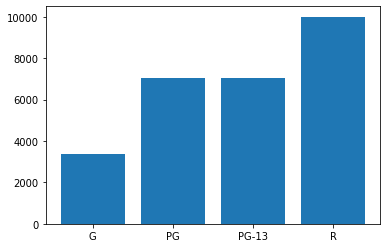

In [349]:
MPA_counts = {MPA : sum(df['MPA'] == MPA) for MPA in ['G', 'PG', 'PG-13', 'R']}
plt.bar(MPA_counts.keys(), MPA_counts.values())
plt.show()

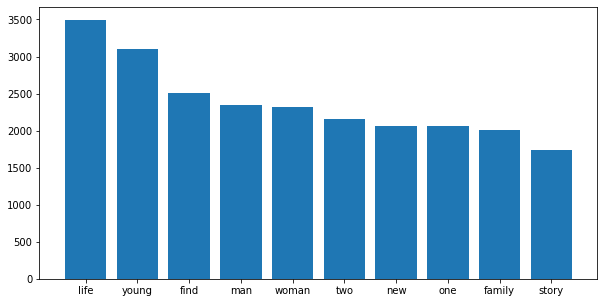

In [350]:
counter = Counter()
df['Normalized_Plot'].apply(lambda lst : ast.literal_eval(lst)).apply(counter.update)

counter_list = [(k, v) for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)]
counter_list = counter_list[:10]
x, y = zip(*counter_list)
plt.figure(figsize=(10, 5), facecolor=None)
plt.bar(x, y)
plt.show()

In [351]:
print('Sentence count:', df['Plot'].apply(sent_tokenize).apply(len).sum())
print('All words(preprocessed words):', sum(counter.values()))
print('Unique words:', len(counter))

Sentence count: 39327
All words(preprocessed words): 422248
Unique words: 34538
